# Feature selection of MGnify data for catboost
### Testing with MGnify data before transition to IMG dataset
* Which features should we drop? Which are most important?
    * ANOVA
    * remove low variance
    * remove those correlated
    * finally RPE model

In [51]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import decomposition
import altair as alt

In [52]:
test_tsv = "/global/cfs/cdirs/kbase/KE-Catboost/mgnify/ipr_aggregated_4.1_fragment.tsv"
biomes_2 = "/global/cfs/cdirs/kbase/KE-Catboost/HK/Mgnify_labels_biomes.csv"
entire_ipr = "/global/cfs/cdirs/kbase/KE-Catboost/mgnify/ipr_aggregated_4.1.tsv"

In [53]:
sensors = [['2CSK_N', 'IPR013727'], ['5TM-Lyt ', 'IPR011620'], ['7TM-DISM', 'IPR011623'], ['7TM-DISM-2', 'IPR011622'], ['Cache_2', 'IPR033480'],['CHASE', 'IPR006189'], ['CHASE_3', 'IPR007891'], ['CHASE2', 'IPR007890'], ['CHASE4', 'IPR007892'], ['CHASE6_C', 'IPR033415'], ['CHASE8', 'IPR033417'], ['CpxA_peri', 'IPR032404'], ['dCache_1', 'IPR033479'], ['GAF', 'IPR003018'], ['HisKA_7TM', 'IPR031621'], ['Histidine_kinase_N','IPR018984'], ['HK_sensor', 'IPR031930'], ['KdpD', 'IPR003852'], ['KdpD transmembrane', 'IPR025201'], ['KinB_sensor_dom', 'IPR031909'], ['MASE1', 'IPR007895'], ['MCP', 'IPR004089'], ['MHYT', 'IPR005330'], ['PAS', 'IPR000014'], ['PAS-2', 'IPR013654'], ['PAS-3', 'IPR013655'], ['PAS-4', 'IPR013656'], ['PAS-fold', 'IPR013767'], ['PBPb', 'IPR001638'], ['PBPe', 'IPR001320'], ['PhoR_single_Cache-like_dom', 'IPR031967'],['Phytochrome_cen-reg', 'IPR013515'], ['Reg_prop', 'IPR011110'], ['RisS_PPD', 'IPR032408'], ['sCache_3', 'IPR033463'], ['Sensor_TM1', 'IPR025908'],['SSF', 'IPR001734'], ['Stimulus_sens_dom', 'IPR025919'], ['TarH', 'IPR003122'], ['UspA', 'IPR006016'], ['CHASE5', 'IPR033414']]
my_columns = pd.Series(['study_id', 'sample_id','IPR003594', 'IPR003661', 'IPR004105'])
sensors = pd.DataFrame(sensors, columns = ['Name', 'IPR'])
my_columns = my_columns.append(sensors.IPR)
#sensors.transpose()

/tmp/ipykernel_4573/3283673818.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  my_columns = my_columns.append(sensors.IPR)


In [66]:
# normalize with Log2 and replacing NaN with 0's
def normalize(df_, log=True):
    dataframe = df_[sensors.IPR]
    dataframe = dataframe[dataframe.sum(axis=1)!=0]
    if log:
        dataframe = np.log2(dataframe)
        dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
        dataframe.fillna(0.0, inplace=True)
    return dataframe

In [61]:
labels = pd.read_csv(biomes_2)
df_full = pd.read_csv(entire_ipr, sep='\t', usecols=my_columns)

In [62]:
sensor_ids = normalize(df_full, log=False)
#sensor_ids[sensor_ids.sum(axis=1)!=0]
df_full=df_full.merge(labels, how='left', on='study_id')
#df_full.study_id.value_counts()

## Which features should we drop? Which are most important?
### Lets try looking at the explained variance

https://towardsdatascience.com/exploring-the-various-ways-to-evaluate-features-for-feature-selection-1142f7788aeb

Used to guide feature exploration/which features can drop. 
#### Could remove variables with a lot of 0s, or with low variation, but they might be useful for the model

In [ ]:
test=sensor_ids.sort_values(by='PC1',ascending=False)
test.iloc[0:10,:].transpose()
test.sum()

### How many items have all 0s, and what biomes are those part of?

In [63]:
sensor_ids = df_full[sensors.IPR]
sensor_ids[sensor_ids.sum(axis=1)!=0] # 53847 rows
sensor_ids[sensor_ids.sum(axis=1)==0] # 44225 rows
44225/(44225+53847) 

0.4509442042580961

## Only 55% of samples have sensory domains.
Going forward, we will remove these from analysis. (updated the normalize function)
Which biomes have a lot of 0's?

In [64]:
zeros_in_biome = pd.DataFrame()
zeros_in_biome['nonzero'] = (sensor_ids.sum(axis=1)!=0)*1
zeros_in_biome['zero'] = (sensor_ids.sum(axis=1)==0)*1
zeros_in_biome['study_id'] = df_full.study_id
zeros_in_biome = zeros_in_biome.merge(labels, how='left', on='study_id')
both_grouped = zeros_in_biome.groupby(['biome', 'study_id']).sum().sort_values('zero', ascending=False)
both_grouped.iloc[0:30]

,,nonzero,zero,Unnamed: 0
biome,study_id,,,
root:Mixed,MGYS00003937,44,13216,12709710.0
root:Environmental:Aquatic:Marine,MGYS00003194,7218,9452,29072480.0
root:Mixed,MGYS00003811,0,3980,4527250.0
root:Environmental:Aquatic:Freshwater:Lake,MGYS00003962,0,1505,201670.0
root:Host-associated:Plants,MGYS00003677,2,1386,966048.0
root:Environmental:Aquatic:Freshwater:Lake,MGYS00003961,0,1143,1983105.0
root:Mixed,MGYS00003748,0,1104,1193424.0
root:Host-associated:Human:Digestive system:Large intestine:Fecal,MGYS00005176,64,746,1194750.0
root:Mixed,MGYS00003924,116,740,1376020.0


No one biome stands out as having more 0's - a lot are marine related. but there are many studies that have all 0 sensors. 
### Perhaps should remove these studies from the dataset?

# Kinds of feature selection / how to look at features
Supervised: 
* wrapper - RFE - search for well-performing subsets of features
* filter - select subsets of features based on relationship with target (stat methods / feature importance methods)
* intrinsic - decision tree - algorithm automatically select features during training
PCA - see PCA in HK_Sensory_Domains_InitialTesting - Dimensionality reduction method

Since we have numberical input, categorical output, two ptions to use are ANOVA (**f_classif()**) and Kendall's statistics.
### Try f_classif() - ANOVA feature selection

In [67]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# generate dataset
X = df_full[sensors.IPR]
y = df_full.study_id

# define feature selection
fs = SelectKBest(score_func=f_classif, k=30)
# apply feature selection
X_selected = fs.fit_transform(X, y)
mask = fs.get_support()
chosen_features = list(sensor_ids.loc[:, mask].columns)
removed_features = [feature for feature in sensor_ids.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: {}'.format(chosen_features))
print('Removed features: {}'.format(removed_features))

Chosen features: ['IPR013727', 'IPR011622', 'IPR033480', 'IPR006189', 'IPR007891', 'IPR007890', 'IPR007892', 'IPR033415', 'IPR033479', 'IPR003018', 'IPR031621', 'IPR003852', 'IPR025201', 'IPR004089', 'IPR005330', 'IPR000014', 'IPR013654', 'IPR013655', 'IPR013656', 'IPR013767', 'IPR001638', 'IPR001320', 'IPR013515', 'IPR011110', 'IPR032408', 'IPR025908', 'IPR001734', 'IPR025919', 'IPR006016', 'IPR033414']
Removed features: ['IPR011620', 'IPR011623', 'IPR033417', 'IPR032404', 'IPR018984', 'IPR031930', 'IPR031909', 'IPR007895', 'IPR031967', 'IPR033463', 'IPR003122']


In [68]:
fit = fs.fit(X, y)
y_df = pd.DataFrame(sensors.IPR)
y_df['ANOVA'] = fit.scores_
print(y_df.sort_values('ANOVA', ascending=False))

          IPR       ANOVA
37  IPR025919  562.671135
35  IPR025908  559.106146
29  IPR001320  261.281278
23  IPR000014  239.184930
31  IPR013515  229.463912
26  IPR013656  228.358500
25  IPR013655  204.101522
27  IPR013767  183.961209
22  IPR005330  166.118034
7   IPR007890  162.177225
6   IPR007891  155.054633
13  IPR003018  144.553161
12  IPR033479  142.323616
33  IPR032408  135.532289
21  IPR004089  133.534811
0   IPR013727  124.757012
18  IPR025201  107.969170
14  IPR031621  101.432339
24  IPR013654   94.291384
5   IPR006189   94.128970
28  IPR001638   87.246741
8   IPR007892   83.816672
39  IPR006016   82.747983
4   IPR033480   79.100785
36  IPR001734   78.475403
32  IPR011110   76.884561
40  IPR033414   74.194113
17  IPR003852   69.856735
9   IPR033415   61.770276
3   IPR011622   53.390452
34  IPR033463   48.266431
2   IPR011623   38.839921
10  IPR033417   37.138808
30  IPR031967   32.172221
1   IPR011620   31.963465
11  IPR032404   20.737233
38  IPR003122   19.034840
20  IPR00789

## Could looks for features with low variance
VarianceThreshold: a feature selector that chooses features based on a given variance threshold. A feature’s values need to display some level of variance in order to have predictive capabilities.

In [207]:
from sklearn.feature_selection import VarianceThreshold

sensor_ids = df_full[sensors.IPR] 
sensor_ids = np.log2(sensor_ids)
sensor_ids.replace([np.inf, -np.inf], np.nan, inplace=True)
sensor_ids.fillna(0.0, inplace=True)
#sensor_ids = sensor_ids[sensor_ids.sum(axis=1)!=0]

vt = VarianceThreshold(threshold=0.5)
vt.fit(sensor_ids)

# find the features that meet the variance threshold
mask = vt.get_support()
chosen_features = list(sensor_ids.loc[:, mask].columns)
removed_features = [feature for feature in sensor_ids.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: {}'.format(chosen_features))
print('Removed features: {}'.format(removed_features))

Chosen features: ['IPR013727', 'IPR011620', 'IPR011623', 'IPR011622', 'IPR033480', 'IPR006189', 'IPR007891', 'IPR007890', 'IPR007892', 'IPR033417', 'IPR032404', 'IPR033479', 'IPR003018', 'IPR031621', 'IPR003852', 'IPR025201', 'IPR007895', 'IPR004089', 'IPR005330', 'IPR000014', 'IPR013654', 'IPR013655', 'IPR013656', 'IPR013767', 'IPR001638', 'IPR001320', 'IPR031967', 'IPR013515', 'IPR011110', 'IPR032408', 'IPR033463', 'IPR025908', 'IPR001734', 'IPR025919', 'IPR003122', 'IPR006016']
Removed features: ['IPR033415', 'IPR018984', 'IPR031930', 'IPR031909', 'IPR033414']


/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


Could remove: ['IPR033415', 'IPR018984', 'IPR031909']
But Perhaps not good idea - just small variance isn't a good measure for selection in our case.

## Selecting features based on correlation with other features
For building inference models, it is ideal for features to have no relationship with each other.

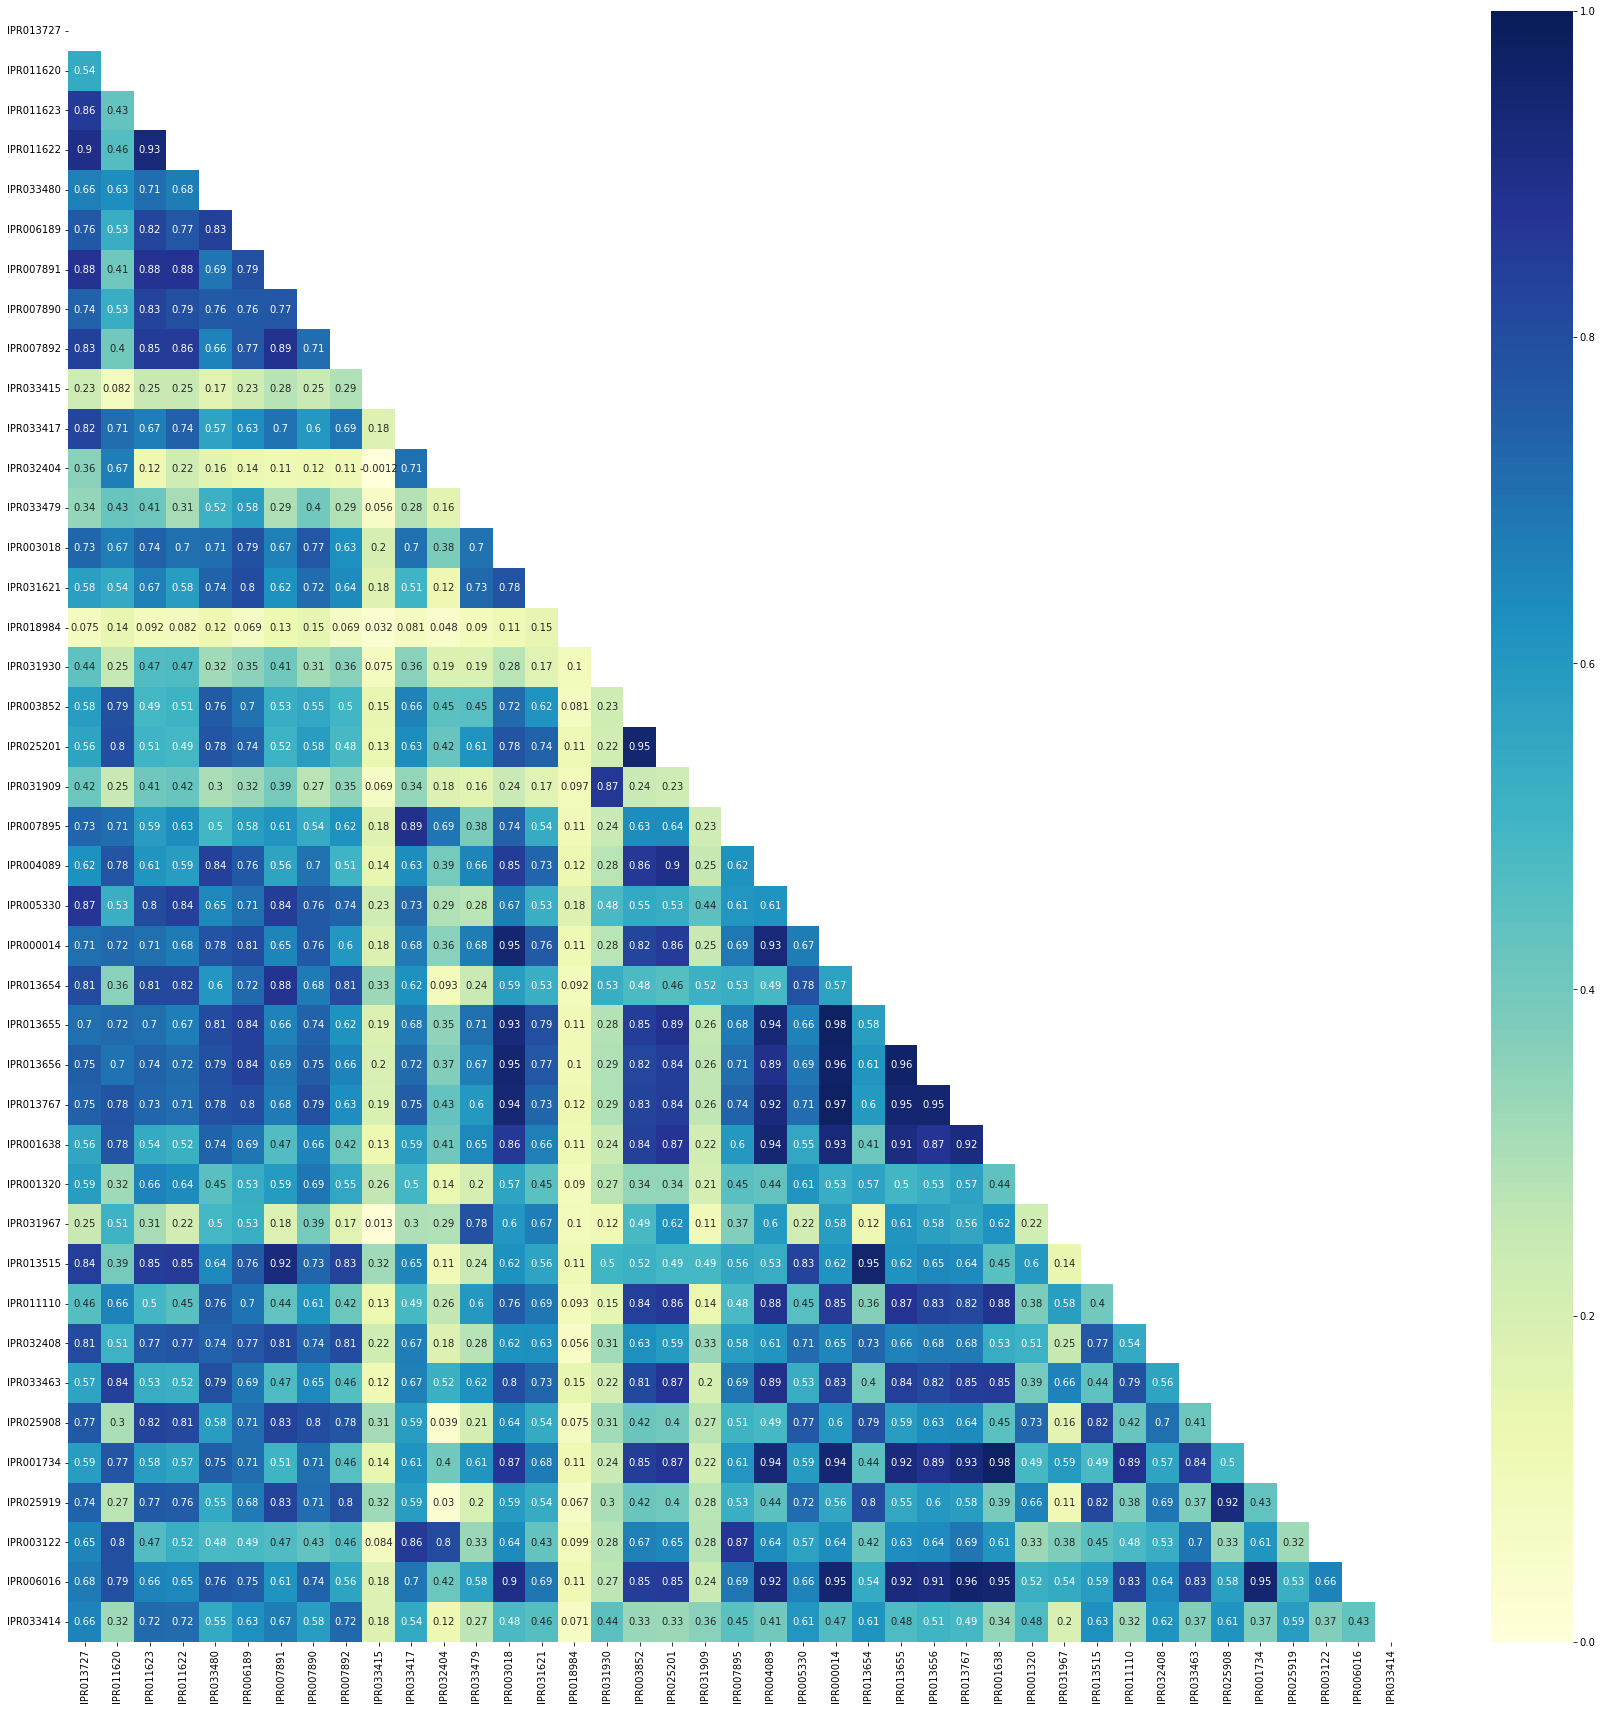

In [208]:
# plot heatmap
plt.figure(figsize=(30,30))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(sensor_ids.corr(), dtype=bool))

# generate heatmap
sns.heatmap(sensor_ids.corr(), annot=True, mask=mask, vmin=0, vmax=1, cmap="YlGnBu")
plt.show()

Could remove: 
* 025201 or 003852
* 013655 or 013656 check 
* 000014 or 013656 check
* 000014 or 013655 check
* 000014 or 013767 check
* 013654 or 013515
* 001638 or 001734
* 011622 or 011623
* 006016 or 001638
* 004089 or 001734


To determine which feature(s) should be eliminated, we can find the features with high variance inflation factor (VIF) values and remove them. Typically, a VIF value of 10 or more is deemed to be too high.
* In code below, start with initial features, then remove one at a time until VIF is low enough / list above is reduced.

In [211]:
# load packages
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = sensor_ids[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [212]:
#considered_features = ['IPR000014', 'IPR013654', 'IPR001638', 'IPR011622', 'IPR025201','IPR013656', 'IPR013655', 'IPR013767', 'IPR003852',
#                       'IPR013515', 'IPR001734', 'IPR011623', 'IPR006016', 'IPR004089']

considered_features = ['IPR011622', 'IPR013656', 'IPR003852','IPR013515', 'IPR006016', 'IPR004089', 'IPR011623']
compute_vif(considered_features)

/tmp/ipykernel_257862/1067063541.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,IPR011622,8.801991
1,IPR013656,9.148626
2,IPR003852,5.023038
3,IPR013515,4.284872
4,IPR006016,9.162776
5,IPR004089,8.833030
6,IPR011623,10.044437


#### Two selection methods after statistics are:

* Select the top k variables: SelectKBest
* Select the top percentile variables: SelectPercentile

### Selecting features based on model performance
A well-known feature selection algorithm that utilizes models is known as recursive feature elimination (RFE).

In [80]:
# load packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [90]:
# get the dataset
def get_dataset():
    dataset = df_full[df_full[sensors.IPR].sum(axis=1)!=0]
    X = dataset[sensors.IPR]
    y = dataset.study_id
    return X, y

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(15, 40):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [ ]:
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

In [92]:
from matplotlib import pyplot

## For 15 - 40 features, how well does the RPE model perform?
Not a super proper way to measure, but it indicates that by 20 features, benefits decrease as increase features.

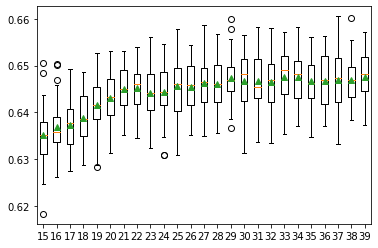

In [93]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [94]:
# report performance
# Below is accuracy if its 10 features.
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.480 (0.003)


## Below print the top 10 (etc) features with decision tree method. 

In [73]:
# use RFE to select 30 features with the decision tree
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe.fit(X_train, y_train)

# show selected features
print('Selected features: {}'.format(list(X.columns[rfe.support_])))
print('Removed features: {}'.format(removed_features))

Selected features: ['IPR033479', 'IPR003018', 'IPR031621', 'IPR025201', 'IPR004089', 'IPR000014', 'IPR001638', 'IPR011110', 'IPR001734', 'IPR006016']
Removed features: ['IPR011620', 'IPR011623', 'IPR033417', 'IPR032404', 'IPR018984', 'IPR031930', 'IPR031909', 'IPR007895', 'IPR031967', 'IPR033463', 'IPR003122']


RFE can also order eliminated features - which are least helpful? Use the ‘.ranking_’ method

In [74]:
feature_importance = pd.DataFrame(zip(X.columns, rfe.ranking_), columns=['Feature', 'Ranking']).sort_values('Ranking')
print(feature_importance)

      Feature  Ranking
39  IPR006016        1
36  IPR001734        1
32  IPR011110        1
28  IPR001638        1
18  IPR025201        1
23  IPR000014        1
21  IPR004089        1
12  IPR033479        1
13  IPR003018        1
14  IPR031621        1
25  IPR013655        2
17  IPR003852        3
34  IPR033463        4
27  IPR013767        5
7   IPR007890        6
20  IPR007895        7
26  IPR013656        8
1   IPR011620        9
0   IPR013727       10
4   IPR033480       11
30  IPR031967       12
5   IPR006189       13
38  IPR003122       14
22  IPR005330       15
29  IPR001320       16
2   IPR011623       17
6   IPR007891       18
33  IPR032408       19
11  IPR032404       20
3   IPR011622       21
10  IPR033417       22
35  IPR025908       23
24  IPR013654       24
8   IPR007892       25
16  IPR031930       26
31  IPR013515       27
37  IPR025919       28
40  IPR033414       29
19  IPR031909       30
9   IPR033415       31
15  IPR018984       32


## IPR ranked to remove from tests 
### Least Important features - When matrix contains entire row with 0's
#### f_classif() - ANOVA
* ['IPR018984'],['IPR031930'],['IPR031909'],['IPR007895'],['IPR003122'],['IPR032404'],['IPR011620'],['IPR031967'],['IPR033417'],['IPR011623'],['IPR033463'],['IPR011622']

#### high correlation to other features
* 'IPR000014', 'IPR001638', 'IPR013655', 'IPR013767', 'IPR001734','IPR025201', 'IPR013654'

#### RFE - DecisionTreeClassifier
* ['IPR018984'],['IPR033415'],['IPR031909'],['IPR033414'],['IPR025919'],['IPR031930'],['IPR013515'],['IPR007892'],['IPR013654'],['IPR025908'],['IPR033417']
### Most important features - When matrix contains entire row with 0's

#### f_classif() - ANOVA
* ['IPR025919'],['IPR025908'],['IPR001320'],['IPR000014'],['IPR013515'],['IPR013656'],['IPR013655'],['IPR013767'],['IPR005330']

#### RFE - DecisionTreeClassifier
* ['IPR006016'],['IPR001734'],['IPR011110'],['IPR001638'],['IPR025201'],['IPR000014'],['IPR004089'],['IPR033479'],['IPR003018'],['IPR031621']
